In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load All Images and Videos

In [ ]:
video_data_path = '/content/drive/MyDrive/data/time'
image_path = '/content/drive/MyDrive/data/input_image.jpg'

In [ ]:
def loadVideos(path):
    """
    path : specifies the path of the videos directory

    returns a list of video files(string) in the directory
    """
    video_files = []
    dir_list = os.listdir(path)
    for item in dir_list:
        x = path+'/'+item
        video_files.append(x)

    return video_files

# Sample 5 equally spaced frames from the video

In [ ]:
def sampleFrames(path, numberOfFrames):
    """
    path : specifies the path of a particular video
    numberOfFrames: specifies how many number of equally spaced frames to be sampled

    returns the set of equally spaced frames 
    """
    cap = cv2.VideoCapture(path)
    frame_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    n = frame_length//numberOfFrames
    ret = 1
    frames = []
    count=0;
    while(ret):
        ret, frame = cap.read()
        # print(ret)
        count += 1
        if(count%n == 0):
            frames.append(frame)
    # print(count)
    # print(frame_length)
    return frames

# HoG descriptor for finding features

In [ ]:
def getDescriptors(path, numberOfFrames):
    """
    path: specifies the list of video files(string) for which the descriptors need to be found
    numberOfFrames: specifies how many number of equally spaced frames to be sampled

    returns a list of descriptors for every video
    """
    
    hog = cv2.HOGDescriptor()
    descriptors = []
    for video in path:
        frames = sampleFrames(video, numberOfFrames)
        v_d = []
        for frame in frames:
            d = hog.compute(cv2.resize(frame, (128, 256)))
            v_d.append(d)
        descriptors.append(v_d)
        print('calculated descriptors for video ', len(descriptors))
    return descriptors

In [ ]:
def getImageDescriptor(imagePath):
    """
    imagePath: specifies the path of the input image 

    returns descriptors for the image
    """
    hog = cv2.HOGDescriptor()
    descriptors = []
    img = cv2.imread(imagePath)
    d = hog.compute(cv2.resize(img, (128, 256)))
    descriptors.append(d)
    
    return descriptors

# Calculate scores for the videos and get the first `K` best matching videos

In [ ]:
def sim(i, v):
    return np.sum(np.minimum(i, v))

In [ ]:
def calcScores(videoDescriptors, imageDescriptor):
    """
    videoDescriptors: Set of descriptors found for every video
    imageDescriptor: descript-ors of the input image

    returns a list of scores for every video with the input image
    """
    scores = []
    for i in range(len(videoDescriptors)):
        maxscore = 0
        
        for d in videoDescriptors[i]:
            score = sim(d, imageDescriptor)
            maxscore = max(maxscore, score)
            # print(score)
        scores.append(maxscore)
    return scores

In [ ]:
def retrieveBestMatchVideo(path, scores):
    """
    path: specifies the list of video files for which the descriptors need to be found
    scores: score for every corresponding video in the path

    return `K` video paths with the best matching scores
    """
    zipped_pairs = zip(scores, path)
 
    z = [x for _, x in sorted(zipped_pairs)]
    print(scores)
    return z[-5:]
    

In [ ]:
videos = loadVideos(video_data_path)
vid_desc = getDescriptors(videos, 5)
img_desc = getImageDescriptor(image_path)
scores = calcScores(vid_desc, img_desc)
bestKvideos = retrieveBestMatchVideo(videos, scores)

calculated descriptors for video  1
calculated descriptors for video  2
calculated descriptors for video  3
calculated descriptors for video  4
calculated descriptors for video  5
calculated descriptors for video  6
calculated descriptors for video  7
calculated descriptors for video  8
calculated descriptors for video  9
calculated descriptors for video  10
[48759.273, 54159.047, 48182.605, 54266.684, 51947.336, 52995.027, 46179.98, 46201.91, 49963.26, 51190.27]


In [ ]:

bestKvideos = retrieveBestMatchVideo(videos, scores)
bestKvideos

[48759.273, 54159.047, 48182.605, 54266.684, 51947.336, 52995.027, 46179.98, 46201.91, 49963.26, 51190.27]


['/content/drive/MyDrive/data/time/04_16_2012_16_01_07.mp4',
 '/content/drive/MyDrive/data/time/04_16_2012_16_00_34.mp4',
 '/content/drive/MyDrive/data/time/04_16_2012_16_10_29.mp4',
 '/content/drive/MyDrive/data/time/04_16_2012_16_00_55.mp4',
 '/content/drive/MyDrive/data/time/04_16_2012_16_05_16.mp4']

In [ ]:
frames = sampleFrames(videos[9], 5)

5


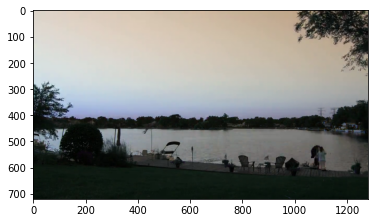

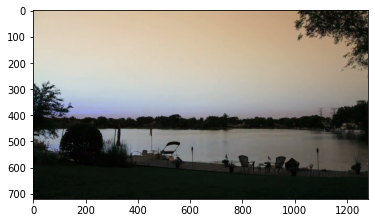

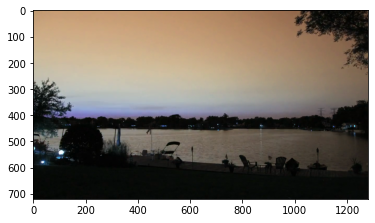

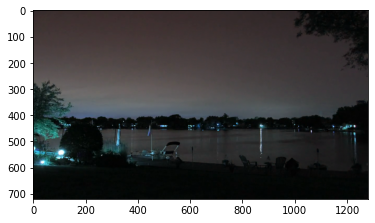

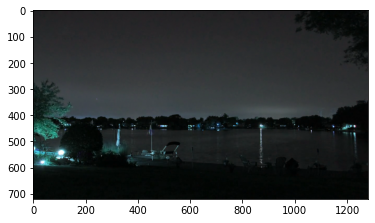

In [ ]:
print(len(frames))
for frame in frames:
    plt.imshow(frame)
    plt.show()

# Get the matching frame

In [ ]:
# def getBestMatchFrame(imagePath, videosPath):
#     """
#     imagePath: path of the input image
#     videosPath: path of the K best matching videos

#     return the frame with the best match
#     """
    
#     pass

# Local Matching

# Color transfer

In [ ]:
def center(px, mean, c):
    res = px-mean[c][0]
    return res

def stdScale(px, stdS, stdT, c):
    res = px*stdT[c][0]
    res /= stdS[c][0]
    return res

def scale(px, mean, c):
    res = px + mean[c][0]
    return res

def clip(px):
    if(px<0):
        px=0
    elif(px>255):
        px=255
    return px

In [ ]:
def transferColor(target, source):

    source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB)
        
    source_mean, source_std = cv2.meanStdDev(source)
    target_mean, target_std = cv2.meanStdDev(target)

    h, w, d = source.shape
    for i in range(h):
        for j in range(w):
            for c in range(d):
                pixel = source[i][j][c]
                r = center(pixel, source_mean, c)

                r = stdScale(r, source_std, target_std, c)
                r = scale(r, target_mean, c)
                r = np.round(r)
                r = clip(r)
                source[i][j][c] = r
        
    result = cv2.cvtColor(source, cv2.COLOR_LAB2BGR)
    # frames.append(result)
    return result

In [ ]:
input = cv2.imread(image_path)
cap = cv2.VideoCapture(videos[9])
ret = 1
count=0
results = []
r2 = []
while(ret):
    ret, frame = cap.read()
    count+=1
    if(ret == False):
        break
    if(count%3==0):
        r = transferColor(frame, input)
        # r2.append(frame)
        results.append(r)
    if(count%50==0):
        print(count)


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400


In [ ]:
# input = cv2.imread(image_path)
# for frame in results:
#     # f = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     f = transferColor(frame, input)
#     f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
#     plt.imshow(f)
#     plt.show()

In [ ]:
def create_directory(dirname):
    try:
        if not os.path.exists(dirname):
            os.mkdir(dirname)
    except:
        pass
dirname="/content/drive/MyDrive/data/images2"


create_directory(dirname)
count=0
for frame in results:
    count+=1
    cv2.imwrite(os.path.join(dirname, "frame%d.jpg"%count), frame)

In [ ]:
import re
path_to_images = "/content/drive/MyDrive/data/images2"
video_output = '/content/drive/video_output.avi'
frames = []
image_files = [f for f in os.listdir(path_to_images)]

for i in range(len(image_files)):
    image_files[i] = path_to_images +'/'+ image_files[i]
image_files.sort(key=lambda f: int(re.sub('\D', '', f)))
print(image_files[0])
for file_ in image_files:
    image = cv2.imread(file_)
    height, width, layers = image.shape
    frame_size=(width, height)
    frames.append(image)

out = cv2.VideoWriter(video_output, cv2.VideoWriter_fourcc(*'DIVX'), 30, frame_size)

for i in range(len(frames)):
    out.write(frames[i])
out.release()

/content/drive/MyDrive/data/images2/frame1.jpg


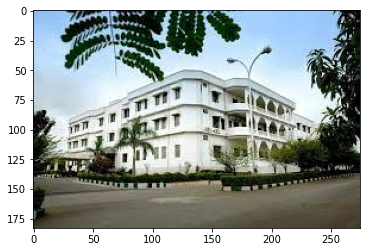

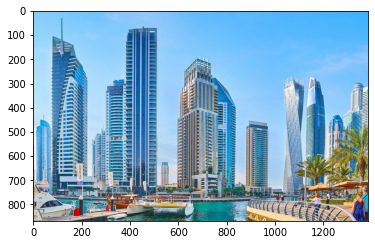

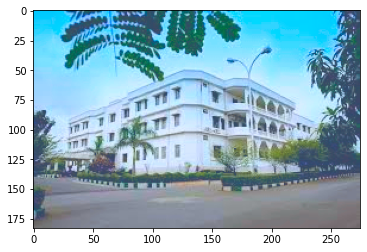

In [ ]:
#Getting output by taking reference image as input
input_image = cv2.imread('/content/drive/MyDrive/data/iith.jpg')
ref_image = cv2.imread('/content/drive/MyDrive/data/ref.jpg')


r = transferColor(ref_image, input_image)
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
plt.imshow(input_image)
plt.show()
plt.imshow(ref_image)
plt.show()
r = cv2.cvtColor(r, cv2.COLOR_BGR2RGB)
plt.imshow(r)
plt.show()

In [ ]:
vid = cv2.VideoCapture(videos[9])

count=0
running=True

# ret, frame = vid.read()
while(running):
    count+=1
    ret, frame = vid.read() ## capture the video by frame
    # print(ret)
    if(ret==False):
        running=False
        break
print(count)

428


In [ ]:

def getTargetFrame(videoPath, input_time):
    '''
    videoPath : specifies the path of the input video
    input_time : user specific time 
    
    Returns the target frame.
    '''
    cap = cv2.VideoCapture(videoPath)
    fps = cap. get(cv2.CAP_PROP_FPS)
    frame_count = int(cap. get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    frame_no = int(fps*input_time)
    ind = int(cap. get(cv2.CAP_PROP_POS_FRAMES))
    cap.set(ind,frame_no);

    ret, frame = cap.read()
    if ret == 1:
        return frame
    return 0
def referenceFrame(videoPath, input_time):
    '''
    input_time = required time of day
    returns = reference frame at the input time
    '''
    if(input_time == 'dayTime'):
        daytime_frame = getTargetFrame(videoPath,1710)
        return daytime_frame
    elif(input_time == 'goldenHour'):
        goldenhour_frame = getTargetFrame(videoPath,1920)
        return goldenhour_frame
    elif(input_time == 'blueHour'):
        bluehour_frame = getTargetFrame(videoPath,120)
        return bluehour_frame
    elif(input_time == 'nightTime'):
        nighttime_frame = getTargetFrame(videoPath,672)
        return nighttime_frame
    else:
        print("Invalid input time!")
        return 0
    

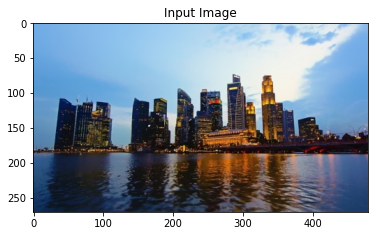

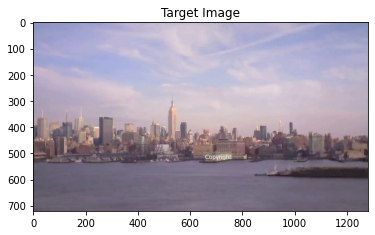

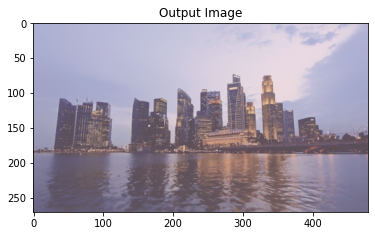

In [ ]:
#Getting results at a given time
#Example - 1
videoPath = '/content/drive/MyDrive/data/time/04_16_2012_16_00_55.mp4'
input_img = cv2.imread(image_path)
ref_frame = referenceFrame(videoPath, 'blueHour')
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.show()

plt.imshow(cv2.cvtColor(ref_frame, cv2.COLOR_BGR2RGB))
plt.title("Target Image")
plt.show()

output_img = transferColor(ref_frame, input_img)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Output Image")
plt.show()

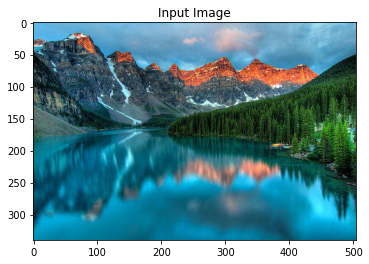

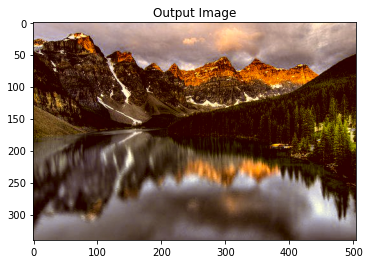

In [ ]:
# Example -2 
videoPath = '/content/drive/MyDrive/data/time/04_16_2012_16_17_54.mp4'
input_img = cv2.imread("/content/drive/MyDrive/data/lake.jpg")
ref_frame = referenceFrame(videoPath, 'blueHour')
plt.imshow(cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB))
plt.title("Input Image")
plt.show()

output_img = transferColor(ref_frame, input_img)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title("Output Image")
plt.show()
